In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from IPython.display import clear_output
%matplotlib inline

In [1]:
import numpy as np
from time import sleep
from copy import deepcopy
import matplotlib.pyplot as plt
from pyuvdata import UVData, UVBeam
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation, PillowWriter

from numpy.fft import fftshift, fftfreq, fft
from scipy import signal

In [2]:
import matplotlib as mpl
mpl.rcParams['xtick.major.size']  = 6
mpl.rcParams['ytick.major.size']  = 6
mpl.rcParams['xtick.minor.size']  = 3
mpl.rcParams['ytick.minor.size']  = 3
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 1.0
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.facecolor'] = 'white'

In [49]:
def colorbar_plotter(fig,ax,im,label):
        
    pos = ax.get_position()
    cbarax = fig.add_axes([pos.x0 + pos.width+0.01, pos.y0, 0.008, pos.height])

    cbar = fig.colorbar(im,cax=cbarax)

    cbar.ax.tick_params(labelsize=16) 
    cbar.ax.set_ylabel(label,fontsize=16)
    
    return cbar

def get_normalized_power_beam(data):
    power = np.real_if_close(data[0,0]*np.conj(data[0,0]) + data[1,0]*np.conj(data[1,0]))
    norm = np.max(power,axis=(1,2,3))
    
    return power/norm[:,np.newaxis,np.newaxis,np.newaxis]

def cross_power_beam(beam1, beam2):
    power = beam1[0,0]*np.conj(beam2[0,0]) + beam1[1,0]*np.conj(beam2[1,0])
    norm = np.max(np.abs(power),axis=(1,2,3))
    return power/norm[:,np.newaxis,np.newaxis,np.newaxis]
        
def dB(x):
    return 10*np.log10(x)

def FFT(d,dt=0.5):
    x = d*(signal.blackmanharris(d.shape[1]))[np.newaxis,:,np.newaxis,np.newaxis]
    return fftshift(fftfreq(d.shape[1],d=dt)),fftshift(fft(x,axis=1),axes=1)

def nearest_idx(data,val):
    return np.abs(data - val).argmin()

In [28]:
beamfile_old = 'NicolasFagnoniBeams/NF_HERA_Dipole_efield_beam.fits'

beamfile_0506 = 'HERA_ccbeam_port5-6.uvbeam'
beamfile_2122 = 'HERA_ccbeam_port21-22.uvbeam'
beamfile_2526 = 'HERA_ccbeam_port25-26.uvbeam'

beam_old = UVBeam()
beam_0506 = UVBeam()
beam_2122 = UVBeam()
beam_2526 = UVBeam()

beam_old.read_beamfits(beamfile_old)
beam_0506.read_beamfits(beamfile_0506)
beam_2122.read_beamfits(beamfile_2122)
beam_2526.read_beamfits(beamfile_2526)

In [29]:
beam_old.freq_interp_kind = 'linear'
beam_old.interpolation_function = 'az_za_simple'
beam_old_interp = beam_old.interp(freq_array=beam_0506.freq_array[0],new_object=True)

In [30]:
data_old = beam_old_interp.data_array

data_0506 = beam_0506.data_array
data_2122 = beam_2122.data_array
data_2526 = beam_2526.data_array

In [50]:
power_old = get_normalized_power_beam(data_old)
power_0506 = get_normalized_power_beam(data_0506)
power_2122 = get_normalized_power_beam(data_2122)
power_2526 = get_normalized_power_beam(data_2526)

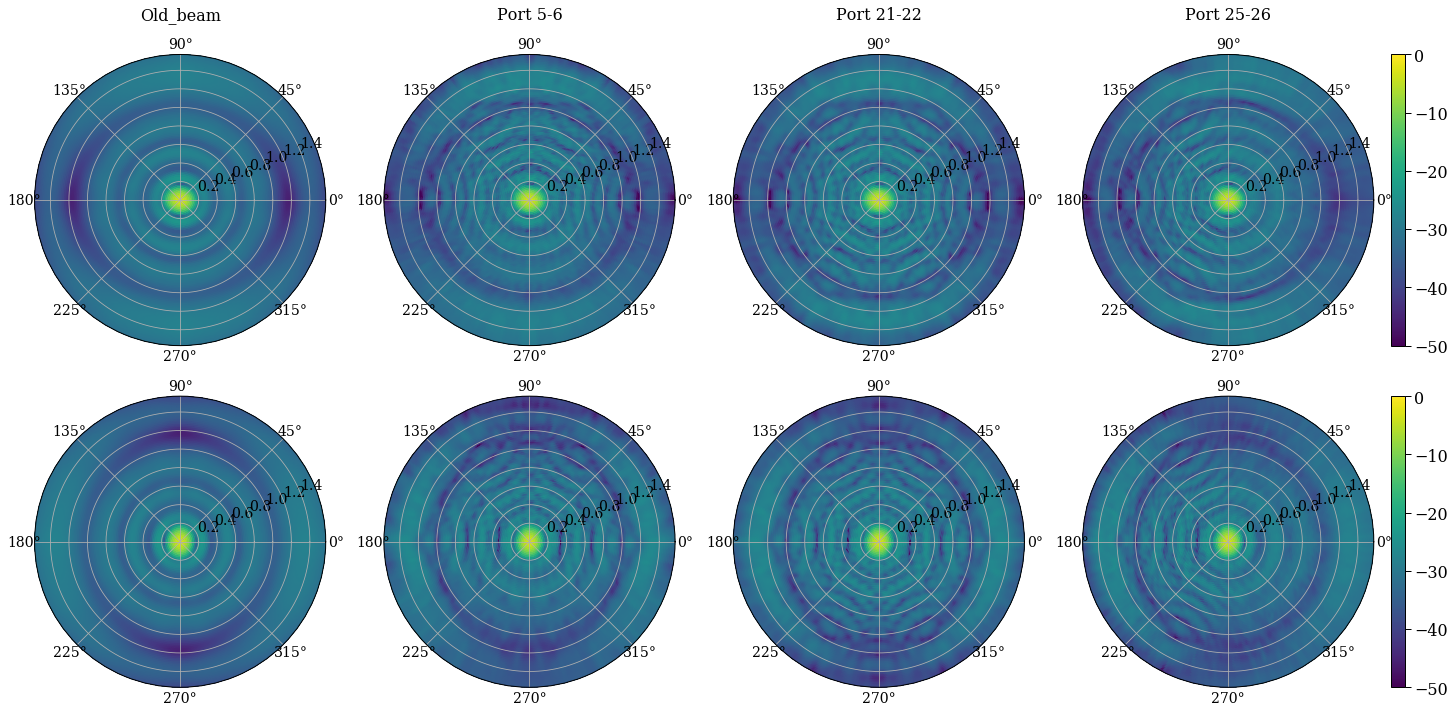

In [51]:
power_beams = [power_old,power_0506,power_2122,power_2526]
titles = ['Old_beam', 'Port 5-6', 'Port 21-22', 'Port 25-26']

theta = beam_0506.axis2_array
phi = beam_0506.axis1_array

AZ, ZA = np.meshgrid(phi,theta)

fig1, axs = plt.subplots(nrows=2,ncols=4,figsize=(24,12),subplot_kw=dict(projection='polar'))
fig1.subplots_adjust(wspace=0.2,hspace=0.1)

for i in range(4):
    for j in range(2):
        im = axs[j,i].scatter(AZ.ravel(),ZA.ravel(),c=dB(power_beams[i][j,200,:,:]).ravel(),vmin=-50,vmax=0.)
        axs[j,i].set_ylim(0,np.pi/2.)
        axs[j,i].tick_params(axis='both',direction='in',which='both',labelsize=14)
        if i==3:
            colorbar_plotter(fig1,axs[j,i],im,r'')        
        if j==0:
            axs[j,i].set_title(titles[i],y=1.1,fontsize=16)

In [52]:
beam_diff = [power_0506 - power_old, power_2122 - power_old, power_2526 - power_old]

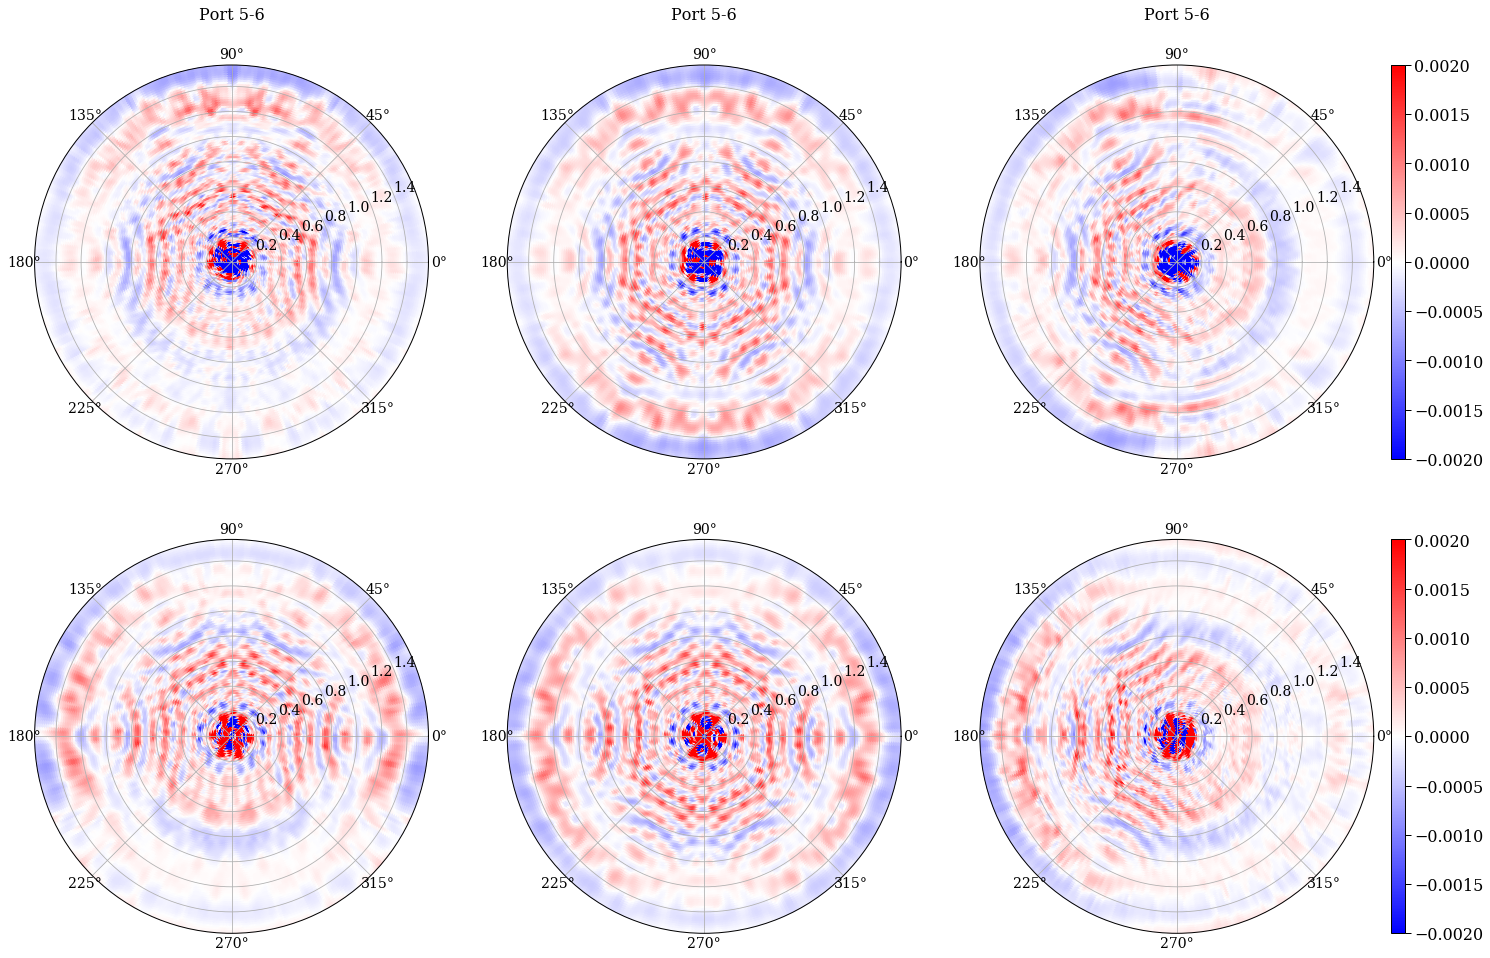

In [53]:
fig2, axs = plt.subplots(nrows=2,ncols=3,figsize=(24,16),subplot_kw=dict(projection='polar'))

for i in range(3):
    for j in range(2):       
        
        im = axs[j,i].scatter(AZ.ravel(),ZA.ravel(),c=beam_diff[i][j,200,:,:].ravel(),vmin=-0.002,vmax=0.002,cmap='bwr')

        axs[j,i].set_ylim(0,np.pi/2.)
        if i==2:
            colorbar_plotter(fig2,axs[j,i],im,r'')
        axs[j,i].tick_params(axis='both',direction='in',which='both',labelsize=14)
        if j==0:    
            axs[j,i].set_title('Port 5-6',y=1.1,fontsize=16)



In [35]:
freqs = beam_0506.freq_array[0,100:301]
df = freqs[1] - freqs[0]

In [54]:
F_ccbeams = []
for i in range(4):
    delays, FPbeam = FFT(power_beams[i][:,100:301],dt=df)
    FPbeam_norm  = np.abs(FPbeam)
    FPbeam_norm /= np.max(FPbeam_norm,axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
    F_ccbeams.append(FPbeam_norm)

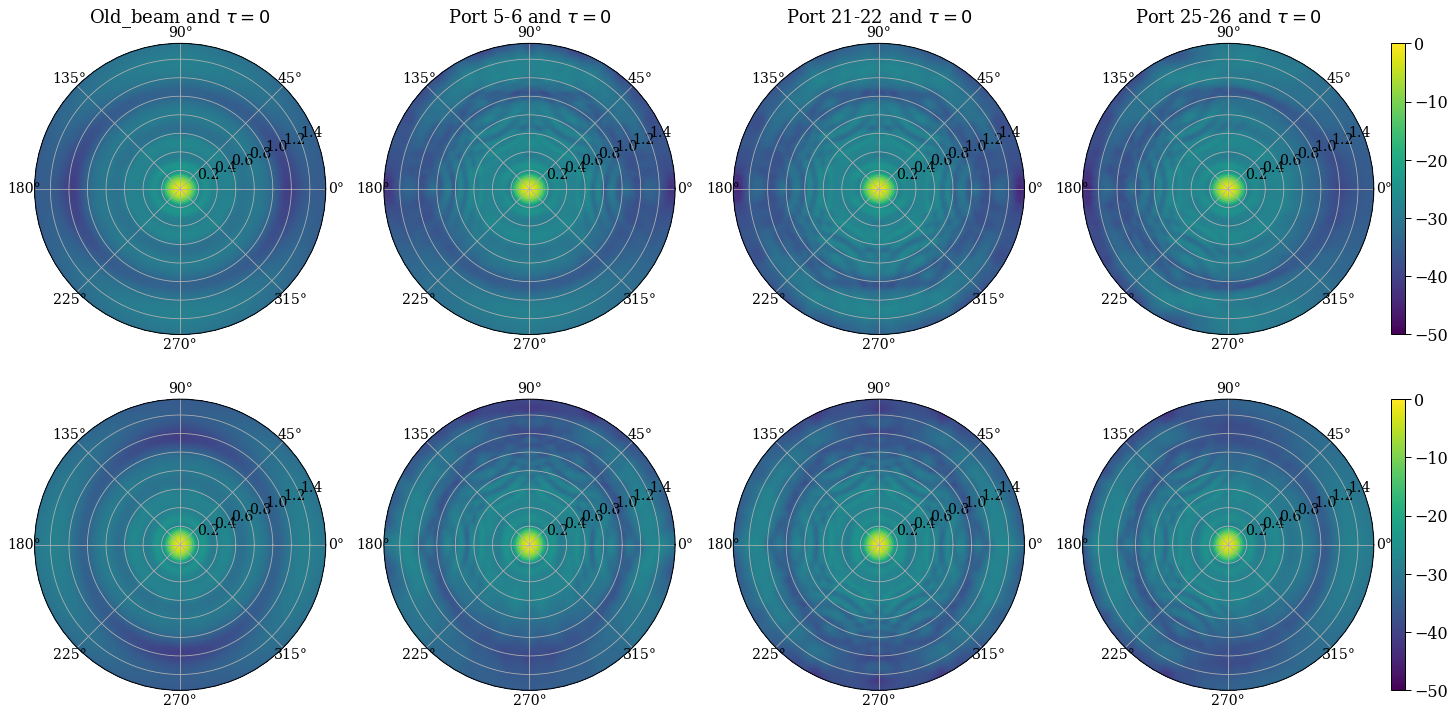

In [55]:
fig3, axs = plt.subplots(nrows=2,ncols=4,figsize=(24,12),subplot_kw=dict(projection='polar'))

for i in range(2):
    for j in range(4):

        im = axs[i,j].scatter(AZ.ravel(),ZA.ravel(),c=dB(F_ccbeams[j][i,100,:,:].ravel()),vmin=-50,vmax=0)  
        
        if j==3:
            colorbar_plotter(fig3,axs[i,j],im,r'')        
        
        axs[i,j].set_ylim(0,0.5*np.pi)
        axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=14)
        if i==0: 
            axs[i,j].set_title(titles[j] + r' and $\tau = 0$',y=1.05,fontsize=18)

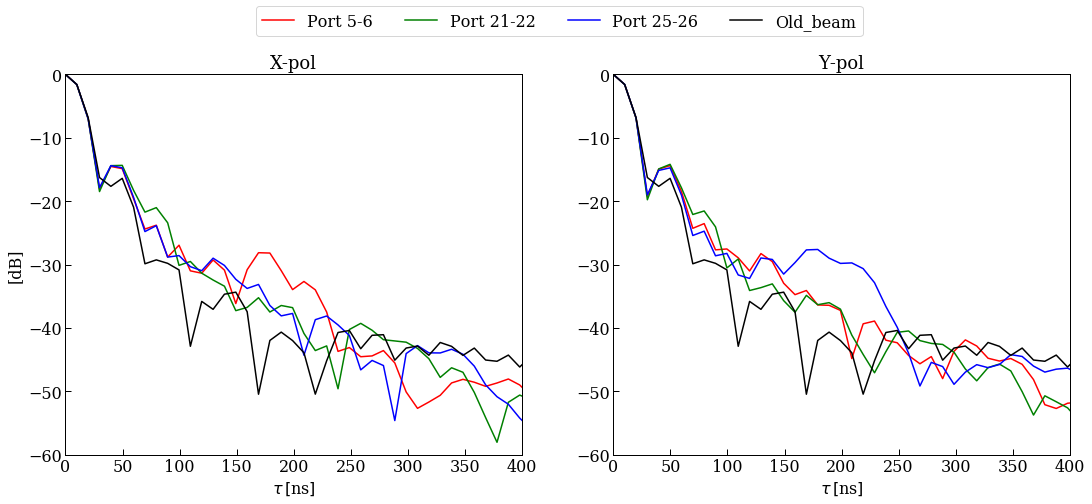

In [63]:
color = ['r','g','b','k']

fig4, axs = plt.subplots(nrows=1,ncols=2,figsize=(18,7)) #,subplot_kw=dict(projection='polar')
#fig4.subplots_adjust(left=0.06,wspace=0.2,right=0.99)

for i in range(2):
    for j in range(4):
        if j!=3:
            axs[i].plot(delays*1.e9,dB(F_ccbeams[j+1][i,:,0,0]),label=titles[j+1],c=color[j])
        else:
            axs[i].plot(delays*1.e9,dB(F_ccbeams[0][i,:,0,0]),label=titles[0],c=color[j])
            
    axs[i].set_xlabel(r'$\tau\,[$ns$]$',fontsize=16)
    if i==0:
        axs[i].set_ylabel('[dB]',fontsize=16)
    axs[i].set_xlim(0,400.)
    axs[i].set_ylim(-60.,0.)
    axs[i].tick_params(axis='both',direction='in',which='both',labelsize=16)
    
axs[0].set_title('X-pol',fontsize=18)
axs[1].set_title('Y-pol',fontsize=18)    

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles,labels,fontsize=16,ncol=4,loc='upper left',bbox_to_anchor=(0.4,1.2))
    

In [64]:
beams_bl = [cross_power_beam(data_0506,data_2122),
            cross_power_beam(data_2122,data_2526),
            cross_power_beam(data_0506,data_2526)]

In [69]:
F_beams = []
for i in range(3):
    delays, Fbeam = FFT(beams_bl[i][:,100:301],dt=df)
    Fbeam_norm  = np.abs(Fbeam)
    Fbeam_norm /= np.max(Fbeam_norm,axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
    F_beams.append(Fbeam_norm)

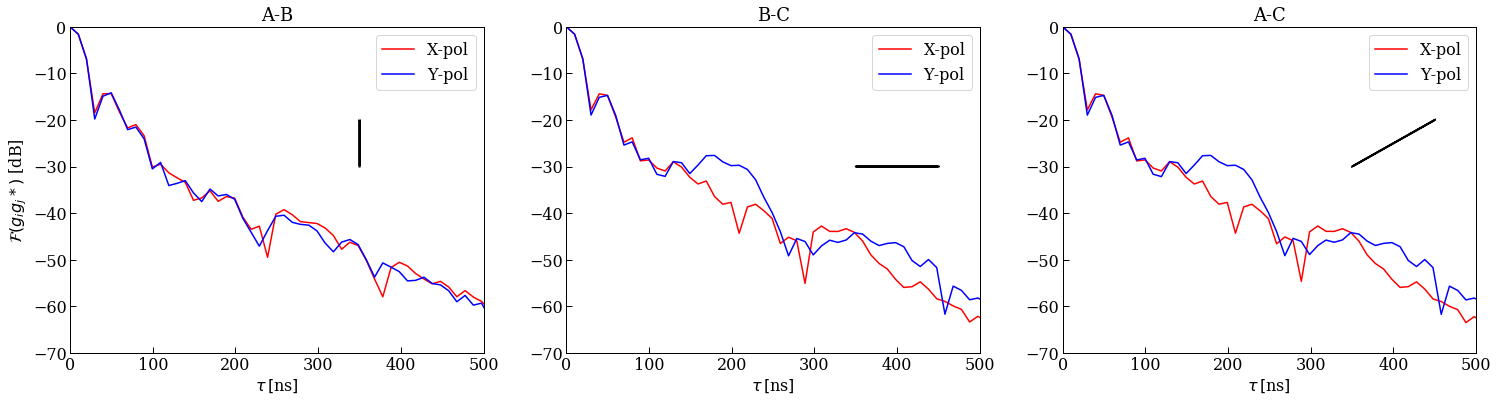

In [70]:
title_labels = ['A-B','B-C','A-C']
#color = ['r','g','b']

arrows = [350.,-30]
dx = [0.,100.,100.]
dy = [10,0,10]

fig5, axs = plt.subplots(nrows=1,ncols=3,figsize=(21,6)) #,subplot_kw=dict(projection='polar')
fig5.subplots_adjust(left=0.06,wspace=0.2,right=0.99)

for i in range(3):
    axs[i].plot(delays*1.e9,dB(F_beams[i][0,:,0,0]),label='X-pol',c='r')
    axs[i].plot(delays*1.e9,dB(F_beams[i][1,:,0,0]),label='Y-pol',c='b')
    axs[i].arrow(arrows[0],arrows[1],dx[i],dy[i],lw=2)

    axs[i].set_xlabel(r'$\tau\,[$ns$]$',fontsize=16)
    if i==0:
        axs[i].set_ylabel('$\mathcal{F}(g_ig_j*)$ [dB]',fontsize=16)
    axs[i].set_xlim(0,500.)
    axs[i].set_ylim(-70.,0.)
    
    axs[i].set_title(title_labels[i],fontsize=18)
    
    handles, labels = axs[i].get_legend_handles_labels()
    axs[i].legend(handles,labels,fontsize=16,ncol=1,loc='upper right')
    axs[i].tick_params(axis='both',direction='in',which='both',labelsize=16)
    

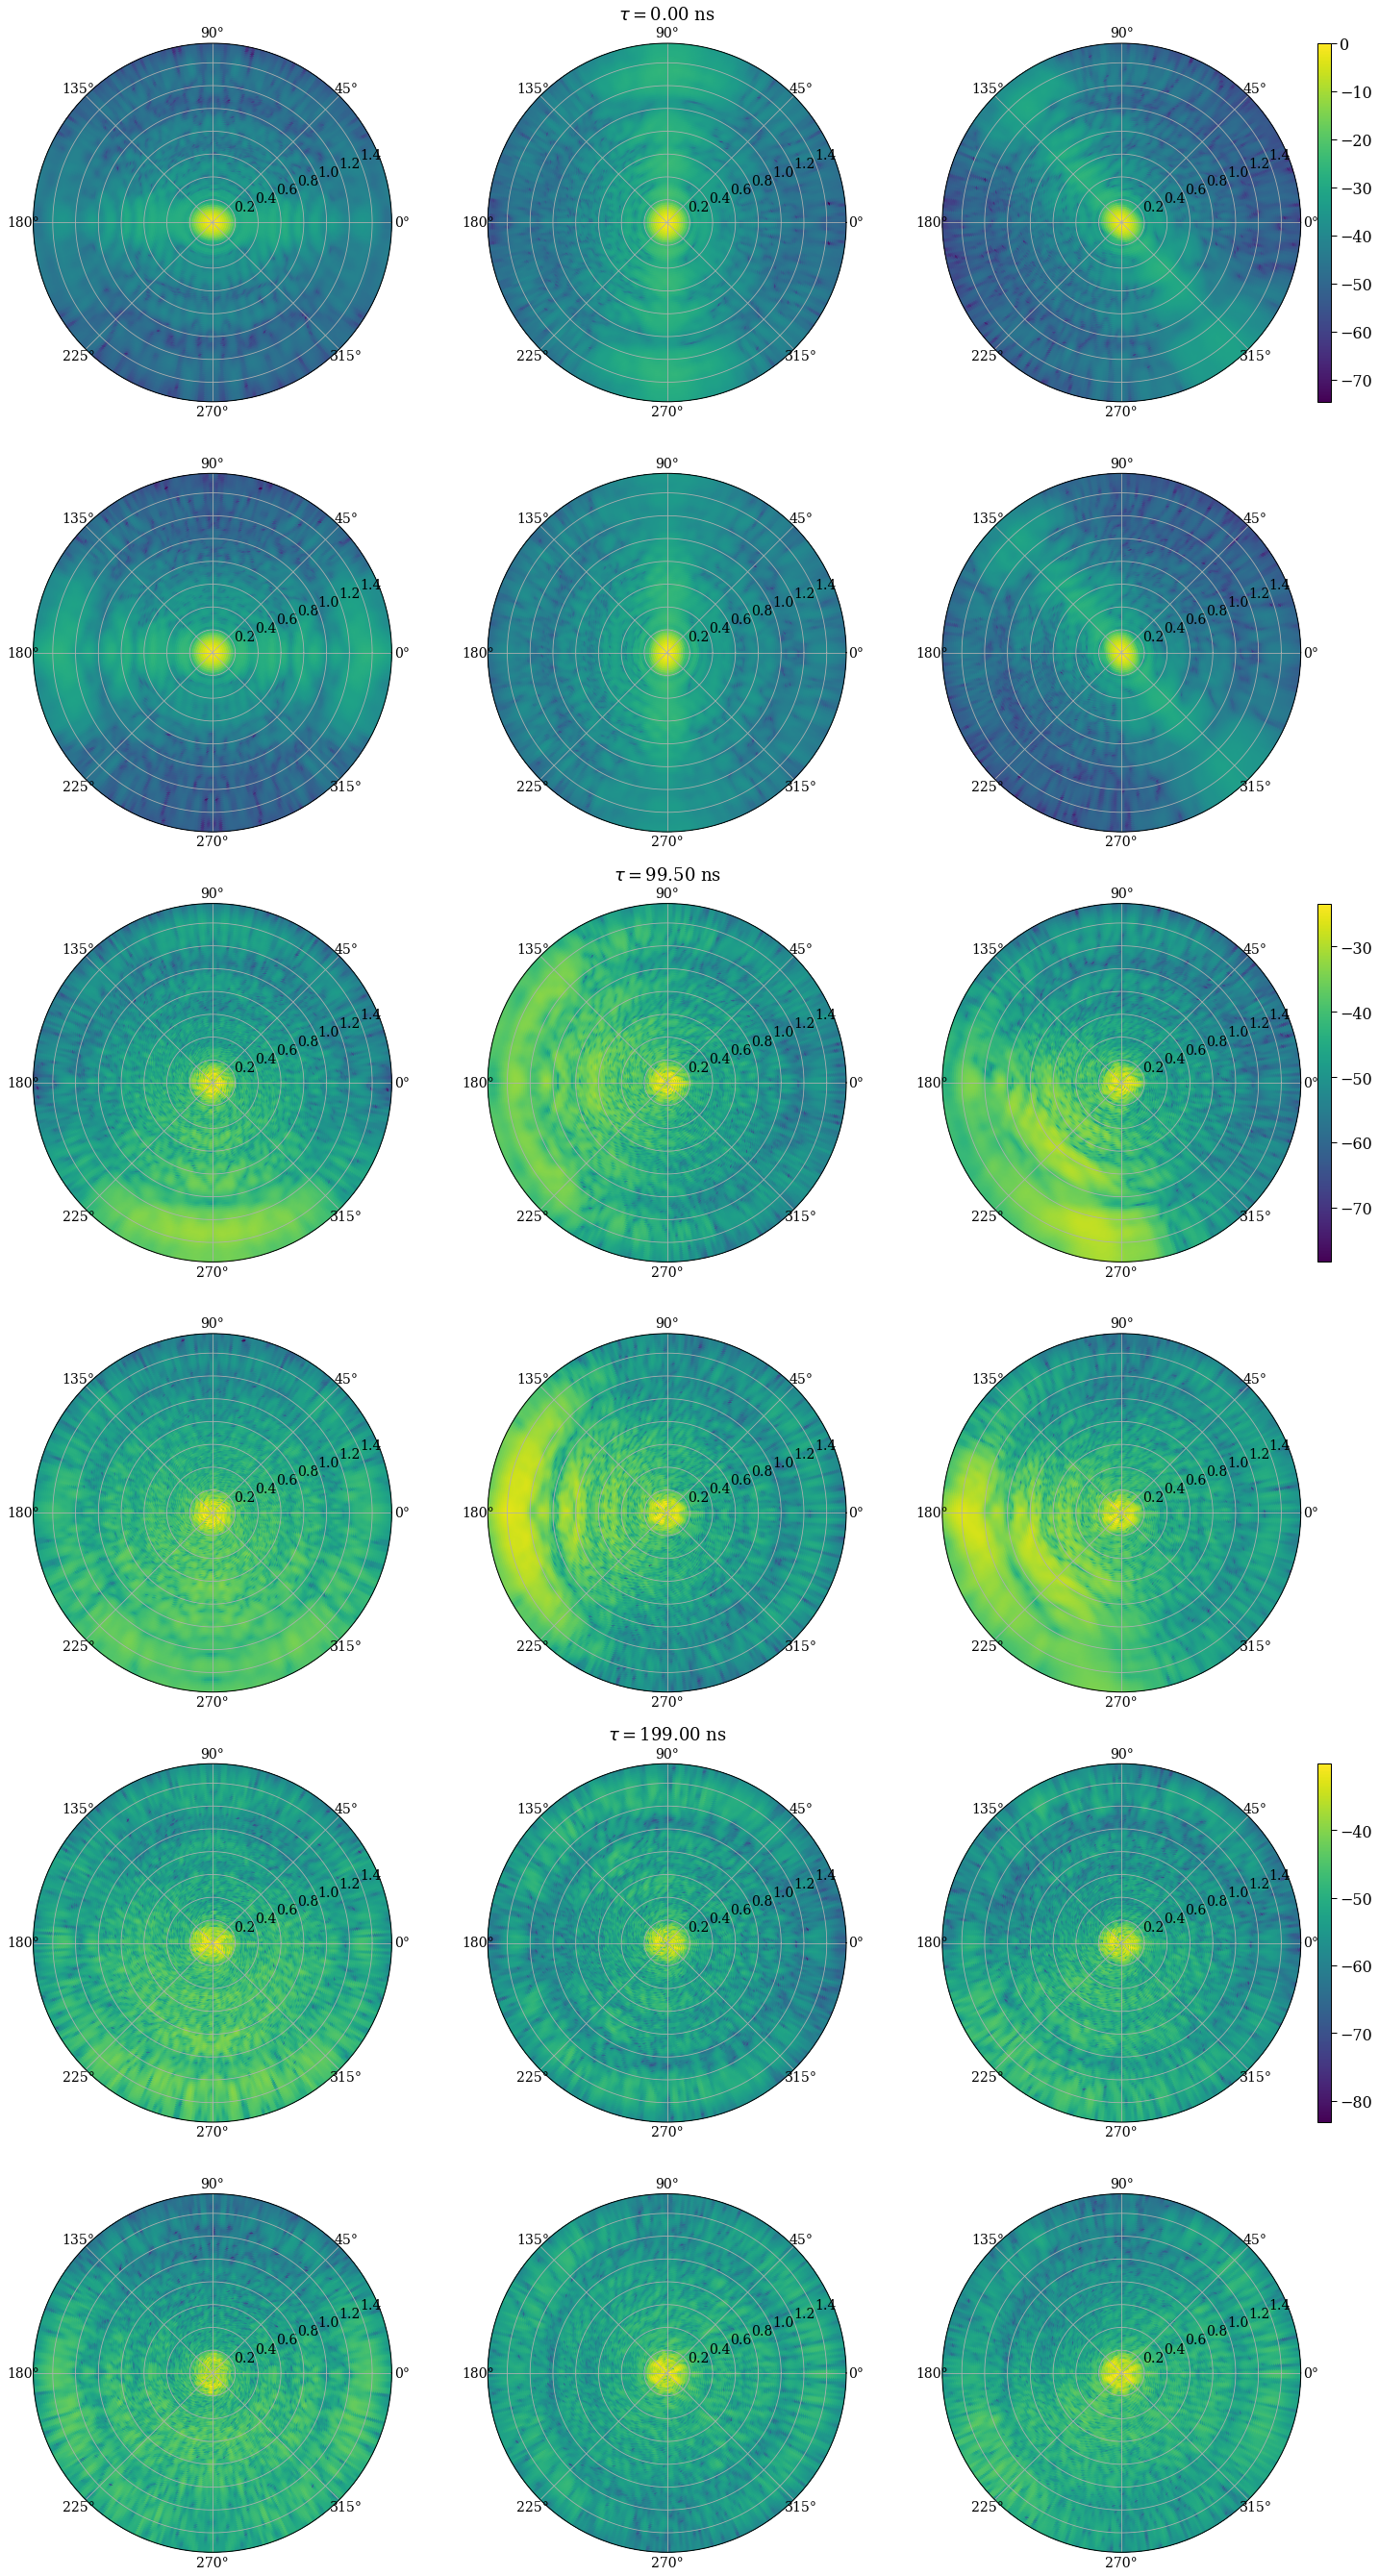

In [71]:
tau_cut = delays[100:]
idx = [0, np.abs(tau_cut - 1.e-7).argmin(), np.abs(tau_cut - 2.e-7).argmin(), np.abs(tau_cut - 4.e-7).argmin()]


fig5, axs = plt.subplots(nrows=6,ncols=3,figsize=(24,48),subplot_kw=dict(projection='polar'))

for i in range(3):
    for j in range(3):

        im1 = axs[2*i,j].scatter(AZ.ravel(),ZA.ravel(),c=dB(F_beams[j][0,100+idx[i],:,:].ravel()))  
        im2 = axs[2*i+1,j].scatter(AZ.ravel(),ZA.ravel(),c=dB(F_beams[j][1,100+idx[i],:,:].ravel()))
        
        if j==2:
            colorbar_plotter(fig5,axs[2*i,j],im1,r'')        
        
        axs[2*i,j].set_ylim(0,0.5*np.pi)
        axs[2*i+1,j].set_ylim(0,0.5*np.pi)             
        axs[2*i,j].tick_params(axis='both',direction='in',which='both',labelsize=14)
        axs[2*i+1,j].tick_params(axis='both',direction='in',which='both',labelsize=14)
    
        if j==1:
            axs[2*i,j].set_title(r'$\tau =$' + '%.2f ns'%(tau_cut[idx[i]]*1.e9),y=1.05,fontsize=18)
    

In [72]:
phi_in = np.array([90.,0.,45.])*np.pi/180. + np.pi
theta_in = np.array([30.,45.,60.])*np.pi/180.
phi_rot = np.array([0.,45.,90.])*np.pi/180.

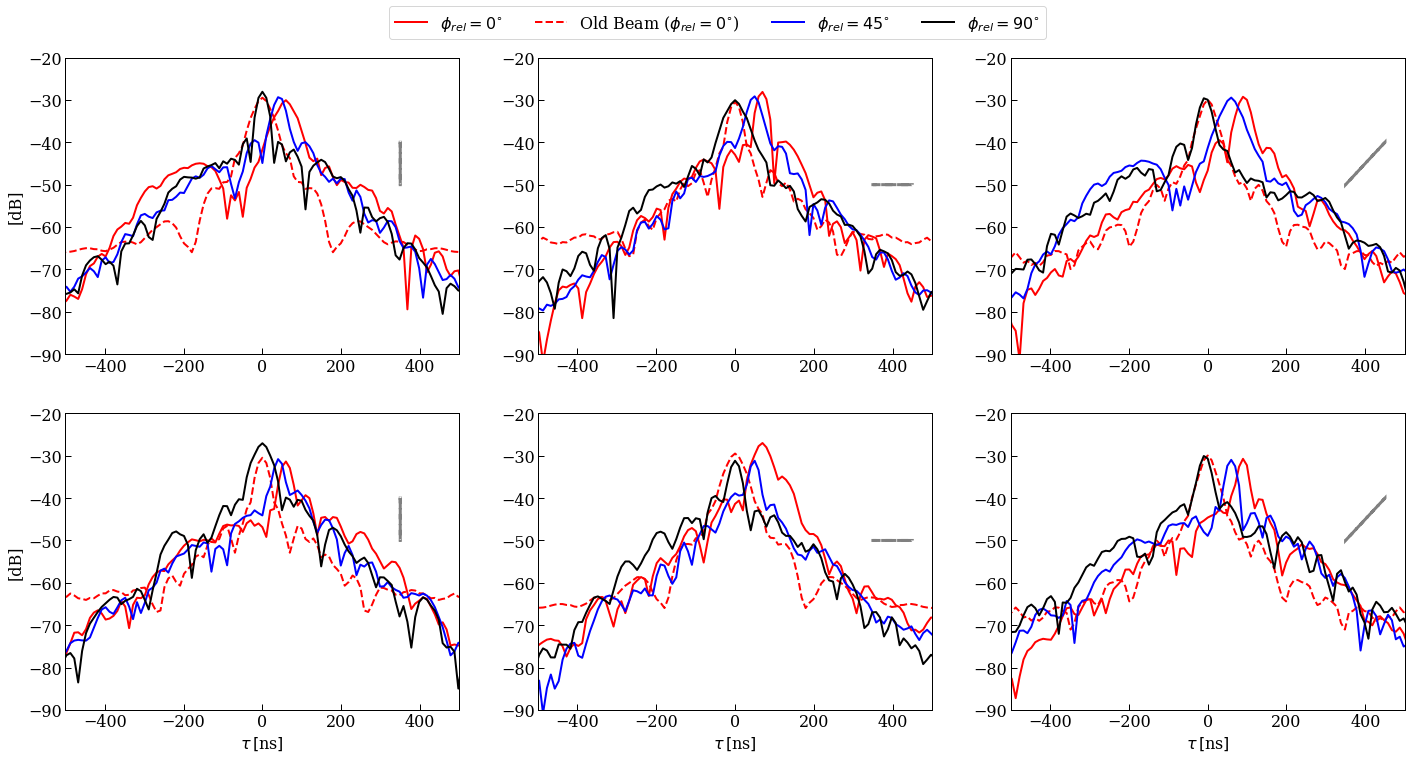

In [74]:
colors = ['r','b','k']
labels = [r'$\phi_{rel} = 0^{\circ}$',r'$\phi_{rel} = 45^{\circ}$',r'$\phi_{rel} = 90^{\circ}$']

fig6, axs = plt.subplots(nrows=2,ncols=3,figsize=(24,12))

for i in range(2):
    for j in range(3):
        for k in range(3):
                
            phi_rel = phi_in[j] + phi_rot[k]
            if phi_rel == 2*np.pi:
                phi_rel = 0.
                    
            axs[i,j].plot(delays*1.e9,dB(F_beams[j][i,:,nearest_idx(theta,theta_in[1]),nearest_idx(phi,phi_rel)]),lw=2,c=colors[k],label=labels[k])
        
            if phi_rot[k]==0.:
                axs[i,j].plot(delays*1.e9,dB(F_ccbeams[0][i,:,nearest_idx(theta,theta_in[1]),nearest_idx(phi,phi_rel)]),lw=2,c=colors[k],ls='--',
                              label=r'Old Beam ($\phi_{rel} = 0^{\circ}$)')
        
        axs[i,j].set_ylim(-90.,-20.)
        axs[i,j].set_xlim(-500.,500.)
        axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=16)
        
        axs[i,j].arrow(arrows[0],-50.,dx[j],dy[j],lw=3,ls='--',color='grey')
        
        if i==1:
            axs[i,j].set_xlabel(r'$\tau\,[$ns$]$',fontsize=16)
        else:
            if j==0:
                handles, labels = axs[i,j].get_legend_handles_labels()
                axs[i,j].legend(handles,labels,fontsize=16,ncol=4,loc='upper left',bbox_to_anchor=(0.8,1.2))
    
        if j==0:
            axs[i,j].set_ylabel('[dB]',fontsize=16)
        
        
        
        

In [76]:
imdata = dB(F_beams[0][:,50:151,:,:])
taus = delays[50:151]

In [ ]:
fig_anim, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,8),subplot_kw=dict(projection='polar'))  
xd = AZ.ravel()
yd = ZA.ravel()

scat1 = axs[0].scatter(xd,yd,c=[],cmap='viridis',vmin=-80.,vmax=0.)
scat2 = axs[1].scatter(xd,yd,c=[],cmap='viridis',vmin=-80.,vmax=0.)

def init():  
    axs[0].set_ylim(0, 0.5*np.pi)
    axs[1].set_ylim(0, 0.5*np.pi)
    axs[0].tick_params(axis='both',direction='in',which='both',labelsize=14)
    axs[1].tick_params(axis='both',direction='in',which='both',labelsize=14)
    
    
def update(i):
    label = r'$\tau =$' + '%.2f ns'%(taus[i]*1.e9)
    print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    scat1.set_color(scat1.to_rgba(imdata[0,i,:,:].ravel()))
    scat2.set_color(scat2.to_rgba(imdata[1,i,:,:].ravel()))
    axs[0].set_title(label,y = 1.1, fontsize=18)
    axs[1].set_title(label,y = 1.1, fontsize=18)
    scat1.set_clim(vmin=-80.,vmax=0.)
    scat2.set_clim(vmin=-80.,vmax=0.)
    
    return scat1, scat2, axs

anim = FuncAnimation(fig_anim, update, frames=len(delays[50:151]), interval=100,init_func=init)
anim.save('ccbeam_AB_dual-pol.gif', dpi=80, writer='imagemagick')

$\tau =$-497.51 ns
$\tau =$-487.56 ns
$\tau =$-477.61 ns
$\tau =$-467.66 ns
$\tau =$-457.71 ns
$\tau =$-447.76 ns
$\tau =$-437.81 ns
$\tau =$-427.86 ns
$\tau =$-417.91 ns
$\tau =$-407.96 ns
$\tau =$-398.01 ns
$\tau =$-388.06 ns
$\tau =$-378.11 ns
$\tau =$-368.16 ns
$\tau =$-358.21 ns
$\tau =$-348.26 ns
$\tau =$-338.31 ns
$\tau =$-328.36 ns
$\tau =$-318.41 ns
$\tau =$-308.46 ns
$\tau =$-298.51 ns
$\tau =$-288.56 ns
$\tau =$-278.61 ns
$\tau =$-268.66 ns
$\tau =$-258.71 ns
$\tau =$-248.76 ns
$\tau =$-238.81 ns
$\tau =$-228.86 ns
$\tau =$-218.91 ns
$\tau =$-208.96 ns
$\tau =$-199.00 ns
$\tau =$-189.05 ns
$\tau =$-179.10 ns
$\tau =$-169.15 ns
$\tau =$-159.20 ns
$\tau =$-149.25 ns
$\tau =$-139.30 ns
$\tau =$-129.35 ns
$\tau =$-119.40 ns
$\tau =$-109.45 ns
$\tau =$-99.50 ns
$\tau =$-89.55 ns
$\tau =$-79.60 ns
$\tau =$-69.65 ns
$\tau =$-59.70 ns
$\tau =$-49.75 ns
$\tau =$-39.80 ns
$\tau =$-29.85 ns
$\tau =$-19.90 ns
$\tau =$-9.95 ns
$\tau =$0.00 ns
$\tau =$9.95 ns
$\tau =$19.90 ns
$\tau =$29.8